## Week 3B: Geospatial Data Analysis and GeoPandas

Sep 17, 2020

## Housekeeping

- [Homework #2](https://github.com/MUSA-550-Fall-2020/assignment-2) due a week from today (9/24)
- Choose a dataset to visualize and explore
    - [OpenDataPhilly](https://opendataphilly.org) or one your choosing
    - Email me if you want to analyze one that's not on OpenDataPhilly

## Agenda for Week #3

**Last lecture**
- Vector data and introduction to GeoPandas
- Spatial relationships and joins
- Visualization for geospatial data

**Today**
- Demo: 311 requests by neighborhood in Philadelphia (continued)
- Exercise: Property assessments by neighborhood

In [1]:
# Let's setup the imports we'll need first
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd

%matplotlib inline

## Last time: 311 requests in 2020

Load 311 requests in Philadelphia from the `data/` directory.

Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/311-service-and-information-requests)

In [2]:
# Load the data from a CSV file into a pandas DataFrame
requests = pd.read_csv('./data/public_cases_fc_2020.csv')

/Users/nhand/opt/miniconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print("number of requests = ", len(requests))

number of requests =  562549


In [4]:
requests.head()

objectid  service_request_id  status       status_notes  \
0   7890359            13127945  Closed  Question Answered   
1   8433329            13376073  Closed                NaN   
2   8421006            13370944    Open                NaN   
3   8433331            13376078  Closed                NaN   
4   8288384            13325114  Closed  Question Answered   

          service_name service_code     agency_responsible    service_notice  \
0  Information Request      SR-IR01      Police Department               NaN   
1  Information Request      SR-IR01  License & Inspections               NaN   
2    Abandoned Vehicle      SR-PD01      Police Department  60 Business Days   
3  Information Request      SR-IR01     Streets Department               NaN   
4  Information Request      SR-IR01  Department of Records               NaN   

  requested_datetime updated_datetime expected_datetime             address  \
0         2020-02-05       2020-02-05        2020-02-05                 NaN   
1         2020-05-22       2020-05-22        2020-05-22                 NaN   
2         2020-05-20       2020-05-20        2020-08-20  1826 PENNINGTON RD   
3         2020-05-22       2020-05-22        2020-05-22                 NaN   
4         2020-04-30       2020-04-30        2020-04-30                 NaN   

  zipcode media_url        lat        lon  
0     NaN       NaN        NaN        NaN  
1     NaN       NaN        NaN        NaN  
2     NaN       NaN  39.977058 -75.270591  
3     NaN       NaN        NaN        NaN  
4     NaN       NaN        NaN        NaN

## First, convert to a GeoDataFrame

Remove the requests missing lat/lon coordinates

In [5]:
requests = requests.dropna(subset=['lat', 'lon']) 

Create Point objects for each `lat` and `lon` combination.

We can use the helper utility function: [`geopandas.points_from_xy()`](https://geopandas.org/reference/geopandas.points_from_xy.html#geopandas.points_from_xy)

In [6]:
requests['Coordinates'] = gpd.points_from_xy(requests['lon'], requests['lat'])

In [7]:
requests['Coordinates'].head()

2     POINT (-75.27059 39.97706)
9     POINT (-75.24549 39.92376)
14    POINT (-75.16257 40.04816)
19    POINT (-75.18500 40.03733)
22    POINT (-75.20961 39.94040)
Name: Coordinates, dtype: geometry

Now, convert to a GeoDataFrame.

**Important**
- Don't forget to set the CRS manually! 
- **The CRS you specify when creating a GeoDataFrame should tell geopandas what the coordinate system the input data is in.**
- Usually you will be reading lat/lng coordinates, and will need to specify the crs as EPSG code 4326
- You should specify the crs as a string using the syntax: `ESPG:4326`



Since we're only using a few EPSG codes in this course, you can usually tell what the CRS is by looking at the values in the Point() objects.

Philadelphia has a latitude of about 40 deg and longitude of about -75 deg.

Our data must be in the usual lat/lng EPSG=4326.

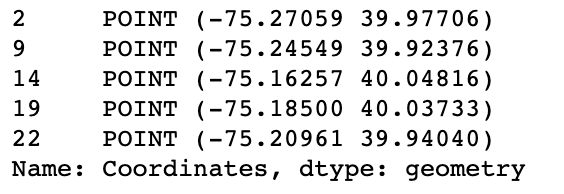

In [8]:
requests = gpd.GeoDataFrame(requests, 
                            geometry="Coordinates", 
                            crs="EPSG:4326")

## Next, identify the top 20 most common requests

Group by the service name and calculate the size of each group:

In [9]:
service_types = requests.groupby('service_name').size()

Sort by the number (in descending order):

In [10]:
service_types = service_types.sort_values(ascending=False)

Slice the data to take the first 20 elements:

In [11]:
top20 = service_types.iloc[:20]
top20  

service_name
Rubbish/Recyclable Material Collection    40776
Illegal Dumping                           19246
Maintenance Complaint                     17969
Abandoned Vehicle                         15933
Information Request                       15240
Graffiti Removal                          11652
Street Light Outage                       10107
Street Defect                              7370
Fire Safety Complaint                      4874
Street Trees                               4450
Sanitation / Dumpster Violation            4244
Construction Complaints                    3859
Agency Receivables                         3451
Maintenance Residential or Commercial      3389
Other (Streets)                            2922
LI Escalation                              2807
Parks and Rec Safety and Maintenance       2228
Traffic Signal Emergency                   2157
Complaint (Streets)                        2100
Alley Light Outage                         1650
dtype: int64

## Let's trim to only the trash-related requests

In [12]:
trash_requests = requests.loc[
    requests["service_name"] == "Rubbish/Recyclable Material Collection"
].copy()

print("The nuumber of trash-related requests = ", len(trash_requests))

The nuumber of trash-related requests =  40776


## Trash collection has been a **BIG** issue in Philadelphia recently


See for example, [this article](https://www.inquirer.com/news/philadephia-trash-recycling-collection-delays-covid-20200806.html) in the Philadelphia Inquirer

## Let's plot the monthly totals for 2020

In [13]:
# Convert the requested datetime to a column of Datetime objects
trash_requests['requested_datetime'] = pd.to_datetime(trash_requests['requested_datetime'])

# Use the .dt attribute to extract out the month name
trash_requests['month'] = trash_requests['requested_datetime'].dt.month_name()

### Note: Setting with a copy warning

TL;DR: This is usually fine! 

If you select a subset of a dataframe (a "slice") and then make changes (like adding a new column), you will get this warning. There is a good discussion of the issue on [StackOverflow](https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas).

You can usually make this go away if you add a `.copy()` after you perform your selection. For example, this warning will go away if we had done:

```python
trash_requests = requests.loc[requests["service_name"] == "Rubbish/Recyclable Material Collection"].copy()
```

In [14]:
totals_by_week = trash_requests.groupby("month", as_index=False).size()

totals_by_week.head()

month  size
0     April  5773
1    August  4414
2  February  2067
3   January  2710
4      July  9622

### Note: I've used the `as_index=False` syntax here

This will force the size() function to return a DataFrame instead of having the `month` column as the index of the resulted groupby operation.

It saves us from having to do the `.reset_index()` function call after running the `.size()` function.

## Plot a bar chart with seaborn

For making static bar charts with Python, seaborn's [`sns.barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) is the best option

In [15]:
import seaborn as sns

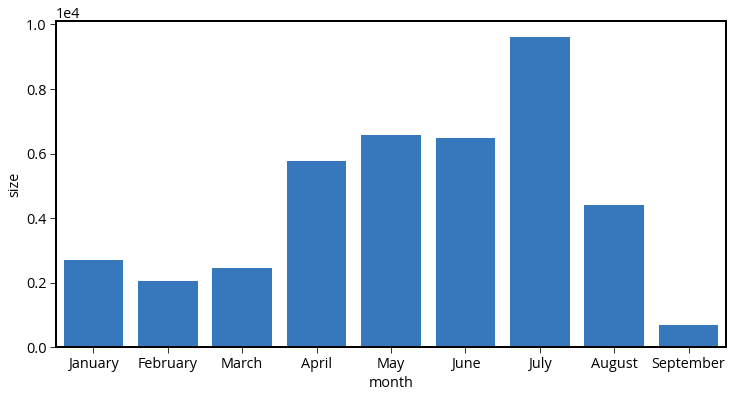

In [16]:
# Initialize figure/axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot!
sns.barplot(
    x="month",
    y="size",
    data=totals_by_week,
    color="#2176d2",
    ax=ax,
    order=["January", "February", "March", "April", "May", "June", "July", "August", "September"],
);

## Example: Improving the aesthetics of matplotlib

The trend is clear in the previous chart, but can we do a better job with the aesthetics? Yes!

For reference, here is a common way to clean up charts in matplotlib:

/Users/nhand/opt/miniconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


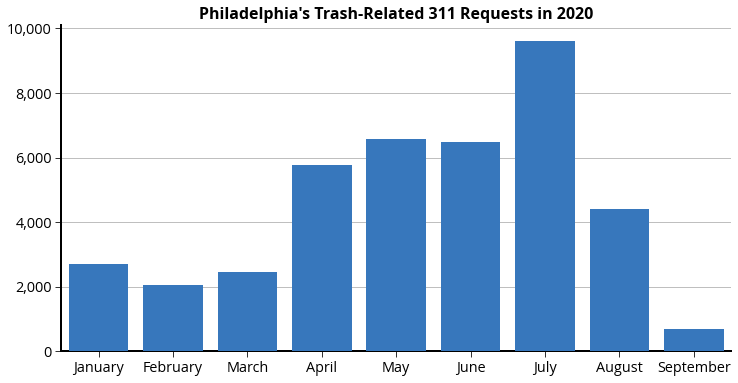

In [17]:
# Initialize figure/axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot!
sns.barplot(
    x="month",
    y="size",
    data=totals_by_week,
    color="#2176d2",
    ax=ax,
    order=["January", "February", "March", "April", "May", "June", "July", "August", "September"],
    zorder=999 # Make sure the bar charts are on top of the grid
)

# Remove x/y axis labels
ax.set_xlabel("")
ax.set_ylabel("")

# Format the ytick labels to use a comma and no decimal places
ax.set_yticklabels([f"{yval:,.0f}" for yval in ax.get_yticks()] )

# Add a grid backgrou d
ax.grid(True, axis='y')

# Remove the top and right axes lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a title
ax.set_title("Philadelphia's Trash-Related 311 Requests in 2020", weight='bold', fontsize=16);

## Now let's look at some geospatial trends!

## Let's convert from lat/lng to Web Mercator

The original data has EPSG=4326. We'll convert to EPSG=3857.

In [18]:
trash_requests = trash_requests.to_crs(epsg=3857)

In [19]:
trash_requests.head()

objectid  service_request_id  status status_notes  \
26    8180042            13269656  Closed          NaN   
27    8180043            13266979  Closed          NaN   
57    7744426            13066443  Closed          NaN   
58    7744427            13066540  Closed          NaN   
160   7801094            13089345  Closed          NaN   

                               service_name service_code  agency_responsible  \
26   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
27   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
57   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
58   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
160  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   

      service_notice requested_datetime updated_datetime expected_datetime  \
26   2 Business Days         2020-04-02       2020-04-06        2020-04-06   
27   2 Business Days         2020-04-02       2020-04-06        2020-04-05   
57   2 Business Days         2020-01-02       2020-01-04        2020-01-06   
58   2 Business Days         2020-01-03       2020-01-04        2020-01-06   
160  2 Business Days         2020-01-15       2020-01-16        2020-01-16   

               address zipcode media_url        lat        lon  \
26     624 FOULKROD ST     NaN       NaN  40.034389 -75.106518   
27   1203 ELLSWORTH ST     NaN       NaN  39.936164 -75.163497   
57    9054 WESLEYAN RD     NaN       NaN  40.058737 -75.018345   
58     2784 WILLITS RD     NaN       NaN  40.063658 -75.022347   
160     6137 LOCUST ST     NaN       NaN  39.958186 -75.244732   

                          Coordinates    month  
26   POINT (-8360819.322 4870940.907)    April  
27   POINT (-8367162.212 4856670.199)    April  
57   POINT (-8351004.015 4874481.442)  January  
58   POINT (-8351449.489 4875197.202)  January  
160  POINT (-8376205.240 4859867.796)  January

## Calculate statistics by Zillow neighborhood

A GeoJSON holding Zillow definitions for Philadelphia neighborhoods is available in the `data/` directory. 

In [20]:
zillow = gpd.read_file('data/zillow_neighborhoods.geojson')
zillow = zillow.to_crs(epsg=3857)

In [21]:
zillow.head()

ZillowName                                           geometry
0   Academy Gardens  POLYGON ((-8348795.677 4875297.327, -8348355.9...
1           Airport  POLYGON ((-8370923.380 4850336.405, -8370799.2...
2    Allegheny West  POLYGON ((-8367432.106 4866417.820, -8367436.0...
3           Andorra  POLYGON ((-8373967.120 4875663.024, -8374106.1...
4  Aston Woodbridge  POLYGON ((-8349918.770 4873746.906, -8349919.8...

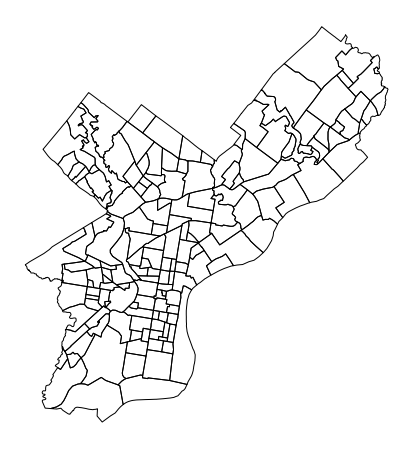

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = zillow.plot(ax=ax, facecolor='none', edgecolor='black')
ax.set_axis_off()
ax.set_aspect("equal")

### Goal: for each neighborhood, calculate the number of trash-related requests

Use the `sjoin()` function to match point data (requests) to polygon data (neighborhoods)

In [23]:
joined = gpd.sjoin(trash_requests, zillow, op='within', how='left')

In [24]:
joined.head()

objectid  service_request_id  status status_notes  \
26    8180042            13269656  Closed          NaN   
27    8180043            13266979  Closed          NaN   
57    7744426            13066443  Closed          NaN   
58    7744427            13066540  Closed          NaN   
160   7801094            13089345  Closed          NaN   

                               service_name service_code  agency_responsible  \
26   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
27   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
57   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
58   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
160  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   

      service_notice requested_datetime updated_datetime expected_datetime  \
26   2 Business Days         2020-04-02       2020-04-06        2020-04-06   
27   2 Business Days         2020-04-02       2020-04-06        2020-04-05   
57   2 Business Days         2020-01-02       2020-01-04        2020-01-06   
58   2 Business Days         2020-01-03       2020-01-04        2020-01-06   
160  2 Business Days         2020-01-15       2020-01-16        2020-01-16   

               address zipcode media_url        lat        lon  \
26     624 FOULKROD ST     NaN       NaN  40.034389 -75.106518   
27   1203 ELLSWORTH ST     NaN       NaN  39.936164 -75.163497   
57    9054 WESLEYAN RD     NaN       NaN  40.058737 -75.018345   
58     2784 WILLITS RD     NaN       NaN  40.063658 -75.022347   
160     6137 LOCUST ST     NaN       NaN  39.958186 -75.244732   

                          Coordinates    month  index_right       ZillowName  
26   POINT (-8360819.322 4870940.907)    April         70.0         Lawndale  
27   POINT (-8367162.212 4856670.199)    April        105.0  Passyunk Square  
57   POINT (-8351004.015 4874481.442)  January        109.0  Pennypack Woods  
58   POINT (-8351449.489 4875197.202)  January        107.0        Pennypack  
160  POINT (-8376205.240 4859867.796)  January         21.0      Cobbs Creek

Note that this operation can be **slow**

Group by neighborhood and calculate the size:

In [25]:
totals = joined.groupby('ZillowName', as_index=False).size()
type(totals)

pandas.core.frame.DataFrame

**Note:** we're once again using the `as_index=False` to ensure the result of the `.size()` function is a DataFrame rather than a Series with the `ZillowName` as its index

In [26]:
totals.head()

ZillowName  size
0   Academy Gardens    74
1    Allegheny West   281
2           Andorra    64
3  Aston Woodbridge    82
4   Bartram Village    29

Lastly, merge Zillow geometries (GeoDataFrame) with the total # of requests per neighborhood (DataFrame).

**Important**

When merging a GeoDataFrame (spatial) and DataFrame (non-spatial), you should always call the `.merge()` function of the spatial data set to ensure that the merged data is a GeoDataFrame. 

For example...

In [27]:
totals = zillow.merge(totals, on='ZillowName')

In [28]:
totals.head()

ZillowName                                           geometry  size
0   Academy Gardens  POLYGON ((-8348795.677 4875297.327, -8348355.9...    74
1    Allegheny West  POLYGON ((-8367432.106 4866417.820, -8367436.0...   281
2           Andorra  POLYGON ((-8373967.120 4875663.024, -8374106.1...    64
3  Aston Woodbridge  POLYGON ((-8349918.770 4873746.906, -8349919.8...    82
4   Bartram Village  POLYGON ((-8372041.314 4856283.292, -8372041.6...    29

## Visualize as a choropleth map

Choropleth maps color polygon regions according to the values of a specific data attribute. *They are built-in to GeoDataFrame objects*.

First, plot the total number of requests per neighborhood.

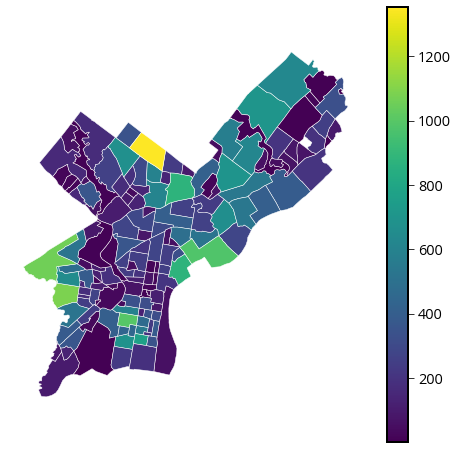

In [29]:
# Create the figure/axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot
totals.plot(
    ax=ax, 
    column="size", 
    edgecolor="white", 
    linewidth=0.5, 
    legend=True, 
    cmap="viridis"
)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

## Can we make the aesthetics better?

## Yes!

- Make the colorbar line up with the axes. The default configuration will always overshoot the axes.
- Explicitly set the limits of the x-axis and y-axis to zoom in and center the map

In [30]:
# Needed to line up the colorbar properly
from mpl_toolkits.axes_grid1 import make_axes_locatable

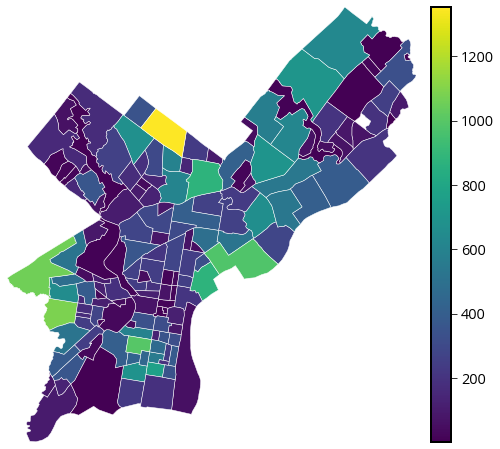

In [31]:
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))

# NEW: Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
totals.plot(
    ax=ax,
    cax=cax,
    column="size",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis",
)

# NEW: Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = totals.total_bounds

# NEW: Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

These improvements are optional, but they definitely make for nicer plots!

## Can we classify the data into bins? 

Yes, built-in to the `plot()` function!

## Classification schemes

Many different schemes, but here are some of the most common ones:

1. "Quantiles" : assigns the same number of data points per bin
1. "EqualInterval" : divides the *range of the data* into equally sized bins
1. "FisherJenks": [scheme](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization) that tries to minimize the variance within each bin and maximize the variances between different bins.
1. "UserDefined": allows you to specify your own bins

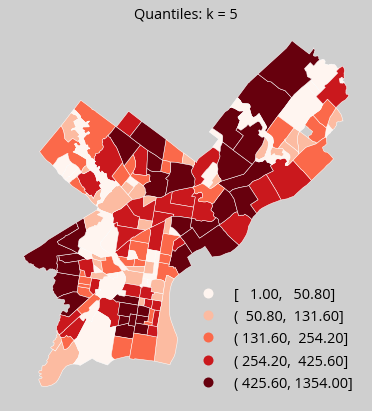

In [32]:
# Quantiles Scheme
fig, ax = plt.subplots(figsize=(10, 7), facecolor="#cfcfcf")

totals.plot(
    ax=ax,
    column="size",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc="lower right"),
    cmap="Reds",
    scheme="Quantiles",
    k=5,
)
ax.set_title("Quantiles: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

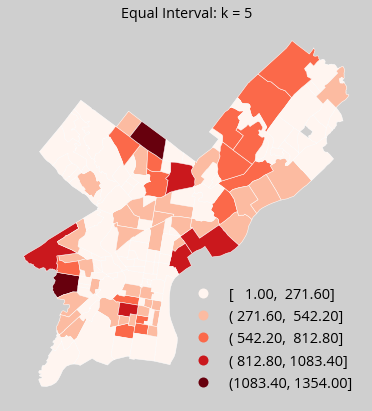

In [33]:
## Equal Interval Scheme
fig, ax = plt.subplots(figsize=(10,7), facecolor='#cfcfcf')
totals.plot(
    ax=ax,
    column="size",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc='lower right'),
    cmap="Reds",
    scheme="EqualInterval",
    k=5 
) 
ax.set_title("Equal Interval: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

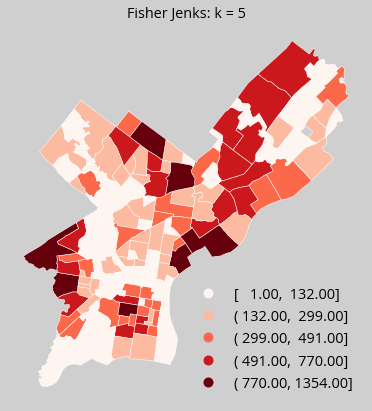

In [34]:
## Fisher Jenks Scheme
fig, ax = plt.subplots(figsize=(10,7), facecolor='#cfcfcf')
totals.plot(
    ax=ax,
    column="size",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc='lower right'),
    cmap="Reds",
    scheme="FisherJenks",
     
)
ax.set_title("Fisher Jenks: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

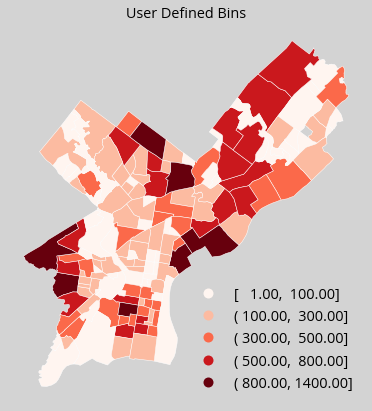

In [35]:
## User Defined Scheme
fig, ax = plt.subplots(figsize=(10,7), facecolor='lightgray')
totals.plot(
    ax=ax,
    column="size",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc='lower right'),
    cmap="Reds",
    scheme="UserDefined", 
    classification_kwds=dict(bins=[100, 300, 500, 800, 1400]) ## NEW: specify user defined bins
)
ax.set_title("User Defined Bins")
ax.set_axis_off()
ax.set_aspect("equal")

## Documentation for classification schemes

The documentation can be found here: https://pysal.org/mapclassify/api.html

Contains the full list of schemes and the function definitions for each.

## Neighborhood sizes still make it hard to compare raw counts

Better to normalize by area: **use the .area attribute of the geometry series**

In [36]:
totals['N_per_area'] = totals['size'] / (totals.geometry.area)

Now plot the normalized totals:

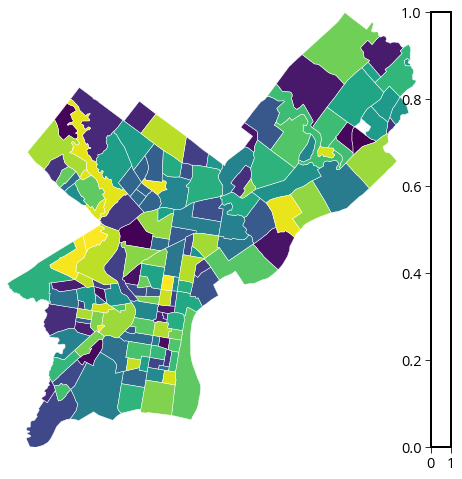

In [37]:
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))

# NEW: Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
totals.plot(
    ax=ax,
    cax=cax,
     
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis",
)

# NEW: Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = totals.total_bounds

# NEW: Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

### Even smarter

Since households are driving the 311 requests, it would be even better to normalize by the number of properties in a given neighborhood rather than neighborhood area

## More advanced: hex bins

Hexagonal bins aggregate quantities over small spatial regions.

**Use matplotlib's `hexbin()` function**

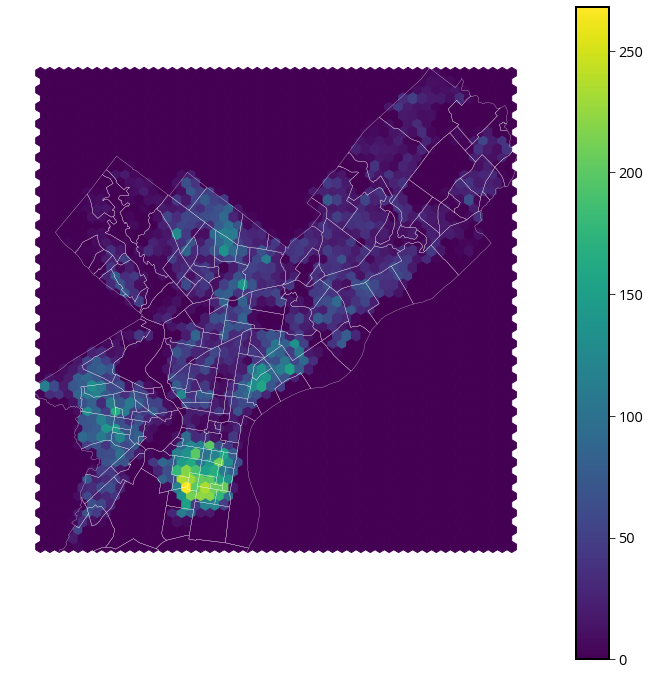

In [38]:
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))


# Extract out the x/y coordindates of the Point objects
xcoords = trash_requests.geometry.x
ycoords = trash_requests.geometry.y

# Plot a hexbin chart
hex_vals = ax.hexbin(xcoords, ycoords, gridsize=50)

# Add the zillow geometry boundaries
zillow.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=0.25)


# add a colorbar and format
fig.colorbar(hex_vals, ax=ax)
ax.set_axis_off()
ax.set_aspect("equal")

## More advanced: adding a basemap

Let's plot a random sample of the requests, with a nice basemap underneath.

We'll use the [contextily](https://contextily.readthedocs.io/en/latest/intro_guide.html) utility package.

In [39]:
import contextily as ctx

In [40]:
# load the city limits data
city_limits = gpd.read_file('./data/City_Limits')

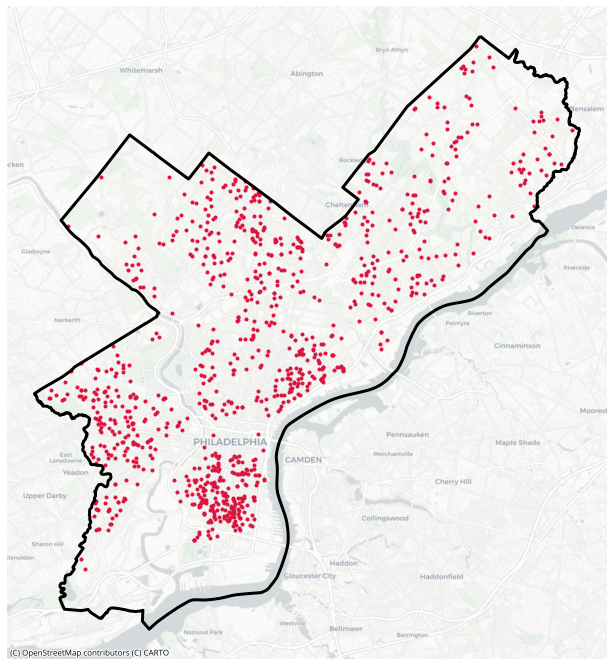

In [41]:
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# Plot a random sample of 1,000 requests as points
random_requests = trash_requests.sample(1000)

# Plot
random_requests.plot(ax=ax, marker='.', color='crimson')

# Add the city limits
city_limits.to_crs(trash_requests.crs).plot(ax=ax, edgecolor='black', linewidth=3, facecolor='none')

# NEW: plot the basemap underneath
ctx.add_basemap(ax=ax, crs=trash_requests.crs, source=ctx.providers.CartoDB.Positron)

# remove axis lines
ax.set_axis_off()

Lots of different tile providers available..

Easiest to use tab complete on `ctx.providers`

In [42]:
ctx.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://{s}.tile.openstreetmap.de/tiles/osmde/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'attribution': '(C) Openstreetmap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by 

### Let's try the "Dark Matter" theme...

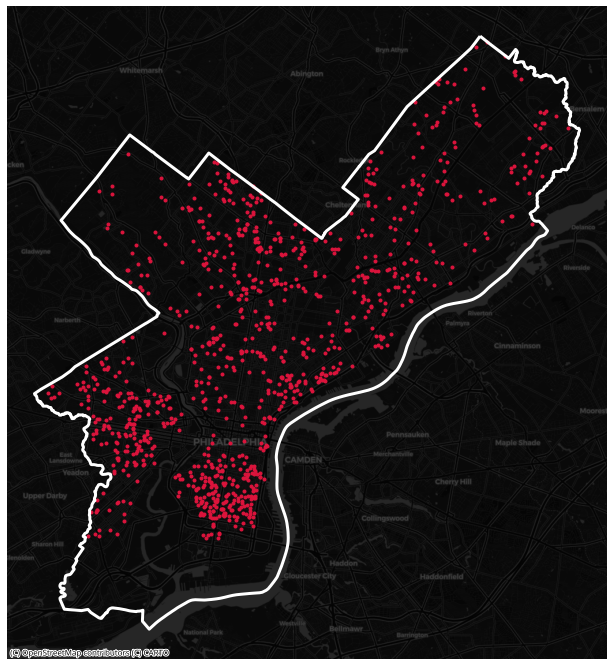

In [43]:
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# plot a random sample of requests
trash_requests.sample(1000).plot(ax=ax, marker='.', color='crimson')

# add the city limits
city_limits.to_crs(trash_requests.crs).plot(ax=ax, edgecolor='white', linewidth=3, facecolor='none')

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=trash_requests.crs, source=ctx.providers.CartoDB.DarkMatter) # NEW: DarkMatter

# remove axis lines
ax.set_axis_off()

## Can we do better?

Yes! Let's add interactivity. We'll start with `altair`...


Altair recently add full support for `GeoDataFrames`, making interactive choropleths very easy to make!

In [44]:
import altair as alt

In [45]:
# IMPORTANT: Altair needs the GeoDataFrame to be in EPSG:4326
totals_4326 = totals.to_crs(epsg=4326)

# plot map, where variables ares nested within `properties`,
alt.Chart(totals_4326).mark_geoshape(stroke="white").encode(
    tooltip=["N_per_area:Q", "ZillowName:N", "size:Q"],
    color=alt.Color("N_per_area:Q", scale=alt.Scale(scheme="viridis")),
).properties(width=500, height=400)

alt.Chart(...)

**Challenge for later:** use altair's *repeated charts* to show several choropleths for different 311 request types at once.

A similar example (using a different dataset) is available in the [altair gallery](https://altair-viz.github.io/gallery/choropleth_repeat.html).

## Exercise: property assessments in Philadelphia

**Goals**: 
Visualize the property assessment values by neighborhood in Philadelphia, using a
1. static choropleth map
1. hex bin map
1. interactive choropleth with altair

**Challenge (if time remaining)**:
Visualize the highest-valued residential and commercial properties as points on top of a `contextily` basemap 

## Dataset

2019 property assessment data:
- from [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- residential properties only — over 460,000 properties 

## Step 1: Load the assessment data

In [46]:
data = pd.read_csv('./data/opa_residential.csv')
data.head()

parcel_number        lat        lng   location  market_value  \
0       71361800  39.991575 -75.128994  2726 A ST       62200.0   
1       71362100  39.991702 -75.128978  2732 A ST       25200.0   
2       71362200  39.991744 -75.128971  2734 A ST       62200.0   
3       71362600  39.991994 -75.128895  2742 A ST       15500.0   
4       71363800  39.992592 -75.128743  2814 A ST       31300.0   

   building_value  land_value  total_land_area  total_livable_area  
0         44473.0     17727.0          1109.69              1638.0  
1         18018.0      7182.0          1109.69              1638.0  
2         44473.0     17727.0          1109.69              1638.0  
3         11083.0      4417.0          1109.69              1638.0  
4         22400.0      8900.0           643.50               890.0

We'll focus on the `market_value` column for this analysis

## Step 2: Convert to a GeoDataFrame

Remember to set the EPSG of the input data — this data is in the typical lat/lng coordinates (EPSG=4326)

In [47]:
data = data.dropna(subset=['lat', 'lng'])
data["Coordinates"] = gpd.points_from_xy(data["lng"], data["lat"])
data = gpd.GeoDataFrame(data, geometry="Coordinates", crs="EPSG:4326")

In [48]:
len(data)

461453

## Step 3: Do a spatial join with Zillow neighbohoods

Use the `sjoin()` function. 

Make sure you CRS's match before doing the sjoin!

In [49]:
zillow.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [50]:
data = data.to_crs(epsg=3857)

In [51]:
gdata = gpd.sjoin(data, zillow, op='within', how='left')

In [52]:
gdata.head()

parcel_number        lat        lng   location  market_value  \
0       71361800  39.991575 -75.128994  2726 A ST       62200.0   
1       71362100  39.991702 -75.128978  2732 A ST       25200.0   
2       71362200  39.991744 -75.128971  2734 A ST       62200.0   
3       71362600  39.991994 -75.128895  2742 A ST       15500.0   
4       71363800  39.992592 -75.128743  2814 A ST       31300.0   

   building_value  land_value  total_land_area  total_livable_area  \
0         44473.0     17727.0          1109.69              1638.0   
1         18018.0      7182.0          1109.69              1638.0   
2         44473.0     17727.0          1109.69              1638.0   
3         11083.0      4417.0          1109.69              1638.0   
4         22400.0      8900.0           643.50               890.0   

                        Coordinates  index_right ZillowName  
0  POINT (-8363321.403 4864718.063)         79.0    McGuire  
1  POINT (-8363319.628 4864736.535)         79.0    McGuire  
2  POINT (-8363318.762 4864742.658)         79.0    McGuire  
3  POINT (-8363310.304 4864778.984)         79.0    McGuire  
4  POINT (-8363293.378 4864865.767)         79.0    McGuire

## Step 4: Make a choropleth of the median market value by neighborhood

Hints: 
- You will need to group by Zillow neighborhood
- Calculate the median market value per neighborhood
- Join with the Zillow neighborhood GeoDataFrame

In [53]:
grouped = gdata.groupby('ZillowName', as_index=False)
median_values = grouped['market_value'].median()

In [54]:
median_values.head()

ZillowName  market_value
0   Academy Gardens      185950.0
1    Allegheny West       34750.0
2           Andorra      251900.0
3  Aston Woodbridge      183800.0
4   Bartram Village       48300.0

In [55]:
median_values = zillow.merge(median_values, on='ZillowName')
median_values['market_value'] /= 1e3 # in thousands

In [56]:
median_values.head()

ZillowName                                           geometry  \
0   Academy Gardens  POLYGON ((-8348795.677 4875297.327, -8348355.9...   
1    Allegheny West  POLYGON ((-8367432.106 4866417.820, -8367436.0...   
2           Andorra  POLYGON ((-8373967.120 4875663.024, -8374106.1...   
3  Aston Woodbridge  POLYGON ((-8349918.770 4873746.906, -8349919.8...   
4   Bartram Village  POLYGON ((-8372041.314 4856283.292, -8372041.6...   

   market_value  
0        185.95  
1         34.75  
2        251.90  
3        183.80  
4         48.30

/Users/nhand/opt/miniconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


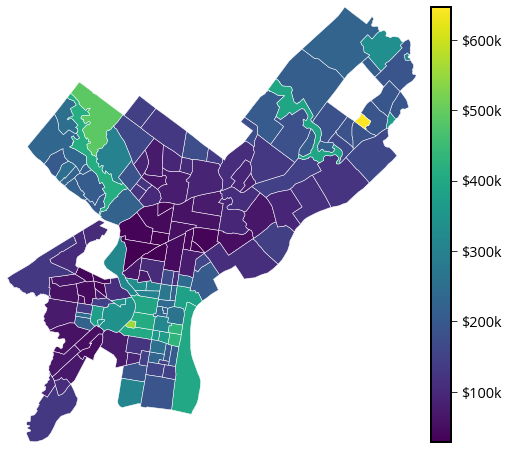

In [57]:
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))

# Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
median_values.plot(
    ax=ax, cax=cax, column="market_value", edgecolor="white", linewidth=0.5, legend=True
)

# Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = median_values.total_bounds

# Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

# Format cax labels
cax.set_yticklabels([f"${val:.0f}k" for val in cax.get_yticks()]);

## Step 5: Make a hex bin map of median assessments

Hints: 
- You will need to use the `C` and `reduce_C_function` of the `hexbin()` function
- Run `plt.hexbin?` for more help
- Try testing the impact of setting `bins='log'` on the resulting map

**Note:** you should pass in the raw point data rather than any aggregated data to the `hexbin()` function

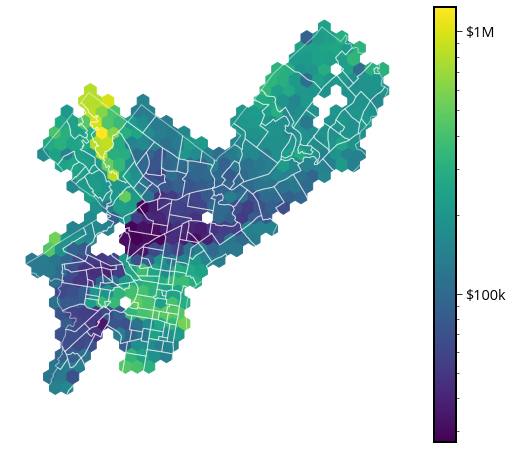

In [58]:
# Create the axes
fig, ax = plt.subplots(figsize=(10, 8))

# Use the .x and .y attributes
# NOTE: we are passing in the raw point values here! 
# Matplotlib is doing the binning and aggregation work for us!
xcoords = gdata.geometry.x
ycoords = gdata.geometry.y
hex_vals = ax.hexbin(
    xcoords, 
    ycoords,
    C=gdata.market_value / 1e3,
    reduce_C_function=np.median,
    bins="log",
    gridsize=30,
)

# Add the zillow geometry boundaries
zillow.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=1, alpha=0.5)

# Add a colorbar and format
cbar = fig.colorbar(hex_vals, ax=ax)
ax.set_axis_off()
ax.set_aspect("equal")

# Format cbar labels
cbar.set_ticks([100, 1000])
cbar.set_ticklabels(["$100k", "$1M"]);

## Step 6: Use altair to make an interactive choropleth

In [59]:
# Convert median values to EPSG=4326
median_values_4326 = median_values.to_crs(epsg=4326)

# Plot the map
alt.Chart(median_values_4326).mark_geoshape(stroke="white").encode(
    tooltip=["market_value:Q", "ZillowName:N"],
    color=alt.Color("market_value:Q", scale=alt.Scale(scheme='viridis'))
).properties(
    width=500, height=400
)

alt.Chart(...)

## Properties with the highest assessed values

*They are all located in Center City*

In [60]:
sorted_properties = gdata.sort_values(by='market_value', ascending=False)
top20 = sorted_properties.head(n=20)

top20

parcel_number        lat        lng             location  \
110862      888501268  39.947159 -75.149844     500-06 WALNUT ST   
83350       888089410  39.948112 -75.169786  1706 RITTENHOUSE SQ   
119309      888095880  39.950683 -75.171026        130 S 18TH ST   
177180      888095438  39.951485 -75.164937       1414 S PENN SQ   
230027      888092327  39.951553 -75.167150         50 S 16TH ST   
124117      888092206  39.951553 -75.167150         50 S 16TH ST   
111012      888501266  39.947159 -75.149844     500-06 WALNUT ST   
154027      888092208  39.951553 -75.167150         50 S 16TH ST   
245208      888501264  39.947159 -75.149844     500-06 WALNUT ST   
5324        888800320  39.954993 -75.170422         1800 ARCH ST   
437426      888501262  39.947159 -75.149844     500-06 WALNUT ST   
300869      888501260  39.947159 -75.149844     500-06 WALNUT ST   
119306      888095876  39.950683 -75.171026        130 S 18TH ST   
390741      888501244  39.947159 -75.149844     500-06 WALNUT ST   
383998      888501258  39.947159 -75.149844     500-06 WALNUT ST   
83348       888089404  39.948112 -75.169786  1706 RITTENHOUSE SQ   
245627      888089406  39.948112 -75.169786  1706 RITTENHOUSE SQ   
83349       888089408  39.948112 -75.169786  1706 RITTENHOUSE SQ   
83347       888089402  39.948112 -75.169786  1706 RITTENHOUSE SQ   
111011      888501256  39.947159 -75.149844     500-06 WALNUT ST   

        market_value  building_value  land_value  total_land_area  \
110862    17000000.0      15640000.0   1360000.0              0.0   
83350     13596500.0      12508780.0   1087720.0              0.0   
119309    12098000.0      11009180.0   1088820.0              0.0   
177180    10800000.0       9936000.0    864000.0              0.0   
230027    10325200.0       9292680.0   1032520.0              0.0   
124117     8928900.0       8036010.0    892890.0              0.0   
111012     8100000.0       7452000.0    648000.0              0.0   
154027     7800000.0       7020000.0    780000.0              0.0   
245208     7800000.0       7176000.0    624000.0              0.0   
5324       7556900.0       6801210.0    755690.0              0.0   
437426     7500000.0       6900000.0    600000.0              0.0   
300869     7200000.0       6624000.0    576000.0              0.0   
119306     7150600.0       6507046.0    643554.0              0.0   
390741     7150000.0       6578000.0    572000.0              0.0   
383998     7000000.0       6440000.0    560000.0              0.0   
83348      6980000.0       6421600.0    558400.0              0.0   
245627     6980000.0       6421600.0    558400.0              0.0   
83349      6980000.0       6421600.0    558400.0              0.0   
83347      6980000.0       6421600.0    558400.0              0.0   
111011     6800000.0       6256000.0    544000.0              0.0   

        total_livable_area                       Coordinates  index_right  \
110862              8900.0  POINT (-8365642.328 4858266.547)        122.0   
83350               7725.0  POINT (-8367862.267 4858404.907)        117.0   
119309              9131.0  POINT (-8368000.327 4858778.265)        117.0   
177180              7622.0  POINT (-8367322.551 4858894.655)        117.0   
230027              7250.0  POINT (-8367568.825 4858904.648)        117.0   
124117              5850.0  POINT (-8367568.825 4858904.648)        117.0   
111012              4155.0  POINT (-8365642.328 4858266.547)        122.0   
154027              5550.0  POINT (-8367568.825 4858904.648)        117.0   
245208              4200.0  POINT (-8365642.328 4858266.547)        122.0   
5324                7738.0  POINT (-8367933.114 4859404.156)         73.0   
437426              4200.0  POINT (-8365642.328 4858266.547)        122.0   
300869              4200.0  POINT (-8365642.328 4858266.547)        122.0   
119306              5384.0  POINT (-8368000.327 4858778.265)        117.0   
390741              5500.0  POINT (-8365642.328 485

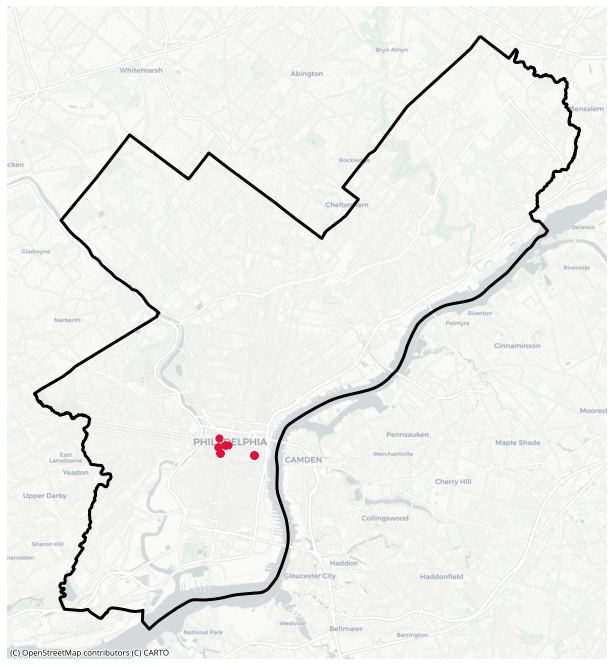

In [61]:
# Create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the top 20 properties by market value
top20.plot(ax=ax, marker=".", color="crimson", markersize=200)

# Add the city limits (with the same CRS!)
city_limits = city_limits.to_crs(top20.crs)
city_limits.plot(
    ax=ax, edgecolor="black", linewidth=3, facecolor="none"
)

# Plot the basemap underneath
ctx.add_basemap(ax=ax, crs=top20.crs, source=ctx.providers.CartoDB.Positron)

# remove axis lines
ax.set_axis_off()

### Let's zoom in on Center City

We can use the total_bounds of the top 20 properties dataframe.

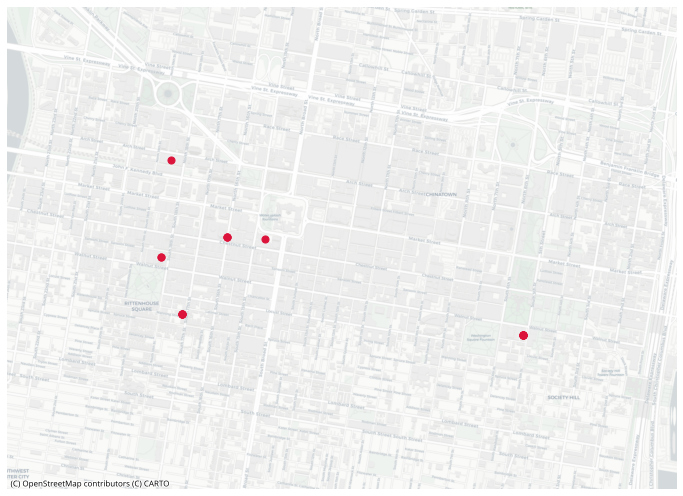

In [62]:
# Create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the top 20 properties by market value
top20.plot(ax=ax, marker=".", color="crimson", markersize=200)

# Add the city limits (with the same CRS!)
city_limits = city_limits.to_crs(top20.crs)
city_limits.plot(
    ax=ax, edgecolor="black", linewidth=3, facecolor="none"
)

# Set the xlims and ylims using the boundaries 
# of the top 20 properties and a padding (in meters)
xmin, ymin, xmax, ymax = top20.total_bounds
PAD = 1000
ax.set_xlim(xmin-PAD, xmax+PAD)
ax.set_ylim(ymin-PAD, ymax+PAD)

# Plot the basemap underneath
ctx.add_basemap(ax=ax, crs=top20.crs, source=ctx.providers.CartoDB.Positron)

# Remove axis lines
ax.set_axis_off()

### Note

The axes limits must be set **before** the call to the `ctx.add_basemap()`. This enables contextily to load a basemap with the proper level of zoom!

--> The top 20 properties are actually all contained within just 6 buildings in Center City

## That's it!

- More interactive viz libraries and raster datasets next week!
- Pre-recorded lecture will be posted on Sunday
- See you next Thursday!